In [1]:
import warnings
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.cluster import contingency_matrix

In [2]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, linewidth=150, precision=2)

In [3]:
df = pd.read_csv("vk.csv")

In [4]:
df.columns

Index(['ID', 'countFriends', 'countFollowers', 'boolComments',
       'countOwnerPosts', 'countOwnerReposts', 'countPhotos', 'countVideos',
       'countLikesPhotoes', 'sex'],
      dtype='object')

In [5]:
data = np.array([df.countFriends, df.countFollowers, df.countOwnerReposts, df.countOwnerReposts, df.countPhotos, df.countVideos]).transpose()

# Normalization

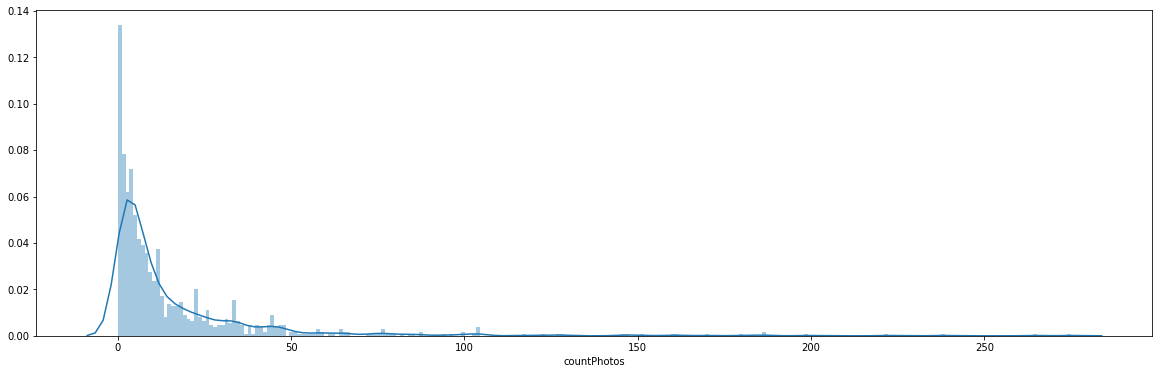

In [6]:
x = df.countPhotos
plt.figure(figsize=(20, 6))
sns.distplot(x, bins=250)

In [7]:
mean_samples = np.mean(x)
std_samples = np.std(x)

In [8]:
# tmp = np.random.choice(x, 10, 50)
# tmp.shape

In [9]:
def compute_confidence(resampled_means, resampled_stds=None):
    
    # pivotal method:
    boots_mean = np.mean(resampled_means)
    if resampled_stds is None:
        boots_std = np.std(resampled_means)
    else:
        boots_std = np.std(resampled_stds)

    lbp = boots_mean - 1.96*boots_std  # left bound pivotal
    rbp = boots_mean + 1.96*boots_std  # right bound pivotal

    # Non-pivotal:
    lower_bound_index = int((len(resampled_means))*.025)
    higher_bound_index = int((len(resampled_means))*.975)
    resampled_mean_sorted = sorted(resampled_means,)

    lbn = resampled_mean_sorted[lower_bound_index]  # left bound non pivotal
    rbn = resampled_mean_sorted[higher_bound_index]  # right bound non pivotal
    
    return boots_mean, boots_std, lbp, rbp, lbn, rbn

# Bootstrapping

In [10]:
def bootstrapping(x, n_resample, n_bootstrap):
    
    """
        x, a 1-D array, representing the random samples.
        n_resample, an int, representing random sampling size
        n_bootstrap, an int, representing the number of 
        repeats in the bootstrapping procedure.

        Returns x_resampled_means, x_resampled_stds, boots_mean, boots_std, lbp, rbp, lbn, rbn, where
        x_resampled_means: list of means of resampled data(x) of the length n_resample,
        x_resampled_stds: list of standard deviations of resampled data(x) of the length n_resample,
        boots_mean: floating number, representing bootstrap mean --i.e mean of means)
        boots_std: floating number, representing bootstrap std --i.e std of stds.

    """

    np.random.seed(42)  # for the sake of reproducibility
    x_resampled_means, x_resampled_stds = [], []

    for _ in range(n_bootstrap):
        x_resampled = np.random.poisson(np.random.choice(x, size=n_resample, replace=True))
        x_resampled_means.append(np.mean(x_resampled))
        x_resampled_stds.append(np.std(x_resampled))  # /np.sqrt(len(x)))

    boots_mean, boots_std, lbp, rbp, lbn, rbn = compute_confidence(resampled_means=x_resampled_means, resampled_stds=x_resampled_stds)

    return x_resampled_means, x_resampled_stds, boots_mean, boots_std, lbp, rbp, lbn, rbn

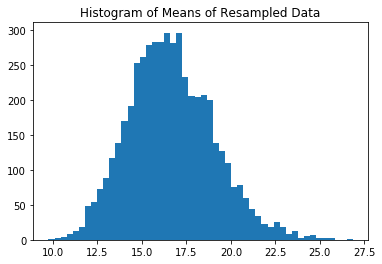

In [11]:
n_resample = 150
n_bootstrap = 5000

x_resampled_means, x_resampled_stds, x_boots_mean, \
x_boots_std, x_lbp, x_rbp, x_lbn, x_rbn = bootstrapping(x=x, n_resample=n_resample, n_bootstrap=n_bootstrap)

plt.hist(x_resampled_means, bins=50)
plt.title("Histogram of Means of Resampled Data")
plt.show()

# Comparison

In [12]:
print("Samples Mean          : %.4f" % mean_samples, " Samples Std             : %.4f" % std_samples)
print("Bootstrap Mean        : %.4f" % x_boots_mean, " Bootstrap Std           : %.4f" % x_boots_std)
print(" ")
print("Left Bound-Pivotal    : %.4f" % x_lbp, " Right Bound-Pivotal     : %.4f" % x_rbp)
print("Left Bound-Non Pivotal: %.4f" % x_lbn, " Right Bound-Non Pivotal : %.4f" % x_rbn)

Samples Mean          : 16.6924  Samples Std             : 28.6555
Bootstrap Mean        : 16.6457  Bootstrap Std           : 6.2115
 
Left Bound-Pivotal    : 4.4712  Right Bound-Pivotal     : 28.8202
Left Bound-Non Pivotal: 12.3000  Right Bound-Non Pivotal : 21.7867


conslusion:

As one can see the original sample means lies between the left and right boundries both in pivotal and not pivotal methods.

# Clustering

### data normalization

In [13]:
mean = np.mean(data, axis=0) # mean
rng = np.ptp(data, axis=0)  # range 
Y = np.divide(np.subtract(data, mean), rng) # normilizad
Y.shape
print(mean)

[1459.55  807.1     6.15    6.15   16.69  361.58]


### Apply Minibatch clustering Algorithm

In [14]:
batch_size = 10
n_repeats = 10
centers = np.array([Y[1, :], Y[31, :], Y[52, :], Y[82,:], Y[111, :]])
n_clusters = len(centers)
n_clusters

5

### Applying K-means (MiniBatch)

In [15]:
np.random.seed(42)
tmp = 0
clusters = {}
idxs = {}
cluster_means = {}
differences = {}

for i in range(n_repeats):
    mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, init=centers, n_init=1, )
    mbk.fit(Y)  # Compute K-mean
    ms = mbk.labels_
    
    # to chose the best clustering results regarding the inertia
    if i == 0 :
        tmp = mbk.inertia_
        delta = 0
    if i != 0:
        delta = tmp - mbk.inertia_
    if delta >= 0:
        tmp = mbk.inertia_
        
        for k in range(n_clusters):
            clusters[k] = data[np.where(ms==k)]
            idxs[k] = np.where(ms==k)[0]
        for k in range(n_clusters):
            cluster_means[k] = np.mean(clusters[k], axis=0)
            differences[k] = 100*(np.divide(np.subtract(cluster_means[k], mean), mean))

In [16]:
cluster_means

{0: array([1198.55,  438.72,   11.24,   11.24,   18.99,  367.84]),
 1: array([1507.98,  447.03,   17.86,   17.86,   15.8 ,  421.17]),
 2: array([666.75, 434.98,   6.08,   6.08,  24.7 , 477.24]),
 3: array([672.11, 419.97,   0.85,   0.85,  11.41, 279.23]),
 4: array([7018.02, 4604.94,    1.78,    1.78,   25.24,  423.78])}

In [17]:
differences

{0: array([-17.88, -45.64,  82.87,  82.87,  13.78,   1.73]),
 1: array([  3.32, -44.61, 190.61, 190.61,  -5.37,  16.48]),
 2: array([-54.32, -46.11,  -1.1 ,  -1.1 ,  47.95,  31.99]),
 3: array([-53.95, -47.97, -86.22, -86.22, -31.66, -22.77]),
 4: array([380.83, 470.56, -71.08, -71.08,  51.23,  17.2 ])}

In [18]:
c1_resampled_means, c1_resampled_stds, c1_boots_mean, \
c1_boots_std, c1_lbp, c1_rbp, c1_lbn, c1_rbn = bootstrapping(x=x[idxs[0]], n_resample=n_resample, n_bootstrap=n_bootstrap)

In [19]:
c2_resampled_means, c2_resampled_stds, c2_boots_mean, \
c2_boots_std, c2_lbp, c2_rbp, c2_lbn, c2_rbn = bootstrapping(x=x[idxs[4]], n_resample=n_resample, n_bootstrap=n_bootstrap)

In [20]:
d12 = np.subtract(np.asarray(c1_resampled_means), np.asarray(c2_resampled_means))  # Difference between 1st and 2nd cluster
d1x = np.subtract(np.asarray(c1_resampled_means), np.asarray(x_resampled_means))  # Difference between 1st and x
d2x = np.subtract(np.asarray(c2_resampled_means), np.asarray(x_resampled_means))  # Difference between 1st and x

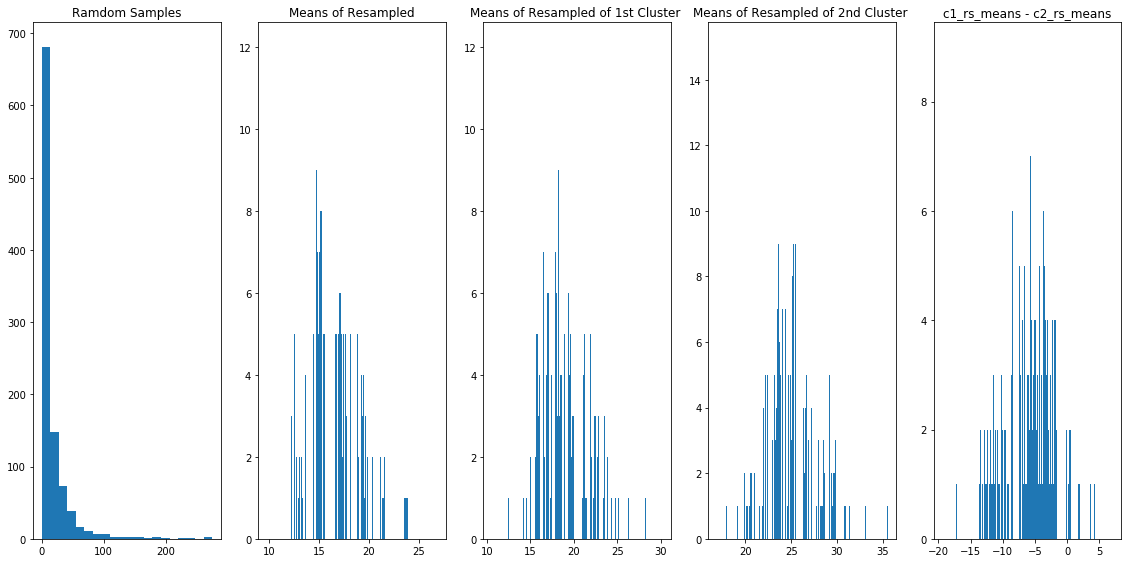

In [31]:
fig = plt.figure(figsize=(19.5, 9.5))

ax = fig.add_subplot(151)
plt.hist(x, bins=20)
plt.title("Ramdom Samples")


ax = fig.add_subplot(152)
plt.hist(x_resampled_means, bins=5000)
plt.title("Means of Resampled")

ax = fig.add_subplot(153)
plt.hist(c1_resampled_means, bins=5000)
plt.title("Means of Resampled of 1st Cluster ")

ax = fig.add_subplot(154)
plt.hist(c2_resampled_means, bins=5000)
plt.title("Means of Resampled of 2nd Cluster ")

ax = fig.add_subplot(155)
plt.hist(d12, bins=5000)
plt.title("c1_rs_means - c2_rs_means")  # rs stands for resampled data
plt.show()

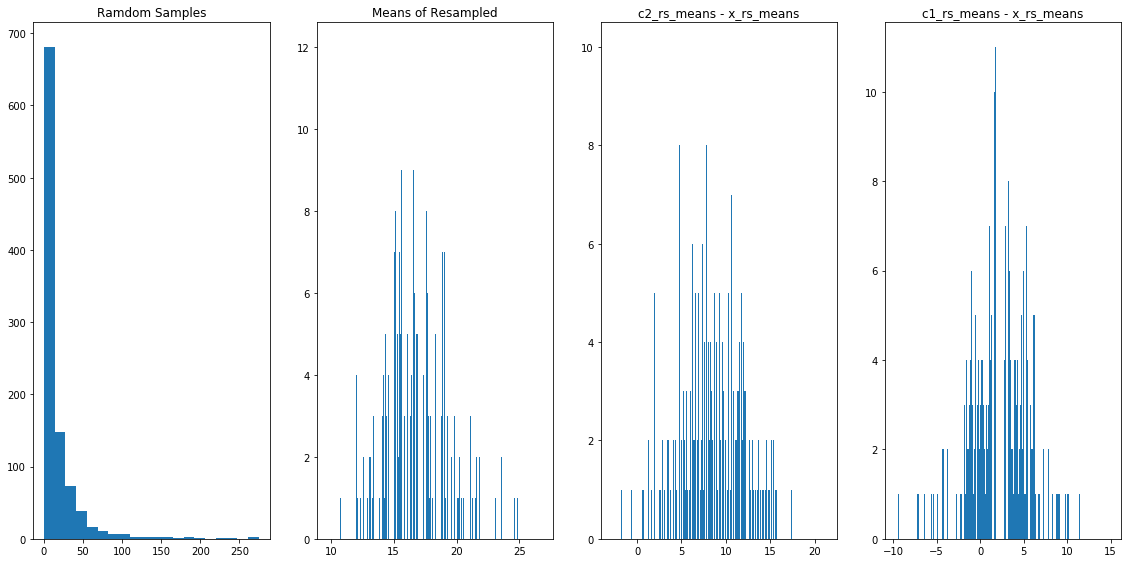

In [32]:
fig = plt.figure(figsize=(19.5, 9.5))

ax = fig.add_subplot(141)
plt.hist(x, bins=20)
plt.title("Ramdom Samples")

ax = fig.add_subplot(142)
plt.hist(x_resampled_means, bins=5000)
plt.title("Means of Resampled")

# ax = fig.add_subplot(153)
# plt.hist(c1_resampled_means, bins=50)
# plt.title("Means of Resampled of 1st Cluster ")

ax = fig.add_subplot(143)
plt.hist(d2x, bins=5000)
plt.title("c2_rs_means - x_rs_means")  # rs stands for resampled data

ax = fig.add_subplot(144)
plt.hist(d1x, bins=5000)
plt.title("c1_rs_means - x_rs_means")  # rs stands for resampled data
plt.show()
